In [4]:
from google.colab import drive
drive.mount('/content/drive')

import os, glob, re, math, random
import numpy as np
import pandas as pd
from PIL import Image

BASE_DIR = "/content/drive/MyDrive/Prac2_ML_Medicine"

TRAIN_DIR = os.path.join(BASE_DIR, "training_set")
TEST_DIR  = os.path.join(BASE_DIR, "test_set")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
!pip -q install opencv-python-headless torchvision tqdm


In [6]:
def load_pixel_size_map(csv_path):
    df = pd.read_csv(csv_path)
    # try to guess columns
    cols = [c.lower().strip() for c in df.columns]
    df.columns = cols

    # candidate filename columns
    fname_candidates = ["filename", "file", "image", "img", "image_id", "id"]
    px_candidates = ["pixel_size", "pixelsize", "pixel_spacing", "spacing", "mm_per_pixel", "mmperpixel"]

    fname_col = next((c for c in fname_candidates if c in df.columns), None)
    px_col = next((c for c in px_candidates if c in df.columns), None)

    if fname_col is None:
        # fallback: first column
        fname_col = df.columns[0]
    if px_col is None:
        # fallback: second column
        if len(df.columns) < 2:
            raise ValueError("Pixel size CSV has <2 columns. Can't infer pixel size.")
        px_col = df.columns[1]

    # normalize filenames (remove extension for stable matching)
    def stem(x):
        x = str(x)
        x = os.path.basename(x)
        return os.path.splitext(x)[0]

    m = {}
    for _, r in df.iterrows():
        m[stem(r[fname_col])] = float(r[px_col])
    return m, df, fname_col, px_col

# locate pixel-size csv
train_px_csv = None
test_px_csv = None
for p in glob.glob(os.path.join(BASE_DIR, "*.csv")):
    name = os.path.basename(p).lower()
    if "train" in name and "pixel" in name:
        train_px_csv = p
    if "test" in name and "pixel" in name:
        test_px_csv = p

print("train_px_csv:", train_px_csv)
print("test_px_csv :", test_px_csv)

train_px_map, train_px_df, c1, c2 = load_pixel_size_map(train_px_csv)
print("pixel size map (train) size:", len(train_px_map))
print("CSV columns used:", c1, c2)


train_px_csv: /content/drive/MyDrive/Prac2_ML_Medicine/training_set_pixel_size_and_HC.csv
test_px_csv : /content/drive/MyDrive/Prac2_ML_Medicine/test_set_pixel_size.csv
pixel size map (train) size: 999
CSV columns used: filename pixel size(mm)


In [7]:
import os, glob

IMG_EXTS = (".png", ".jpg", ".jpeg", ".bmp", ".tif", ".tiff")

print("TRAIN_DIR =", TRAIN_DIR)
print("Exists TRAIN_DIR?", os.path.exists(TRAIN_DIR))

def list_train_images(root):
    # take all images but exclude annotation masks
    imgs = []
    for ext in IMG_EXTS:
        imgs += glob.glob(os.path.join(root, f"**/*{ext}"), recursive=True)
    imgs = [p for p in imgs if "_annotation" not in os.path.basename(p).lower()]
    return sorted(imgs)

def list_test_images(root):
    imgs = []
    for ext in IMG_EXTS:
        imgs += glob.glob(os.path.join(root, f"**/*{ext}"), recursive=True)
    return sorted(imgs)

train_images = list_train_images(TRAIN_DIR)
test_images  = list_test_images(TEST_DIR)

print("train_images:", len(train_images))
print("test_images :", len(test_images))
print("sample train:", [os.path.basename(x) for x in train_images[:6]])

def find_annotation_for_image(img_path):
    # 000_HC.png -> 000_HC_Annotation.png (case-insensitive check)
    base = os.path.splitext(os.path.basename(img_path))[0]
    cand1 = os.path.join(TRAIN_DIR, base + "_Annotation.png")
    cand2 = os.path.join(TRAIN_DIR, base + "_annotation.png")
    if os.path.exists(cand1): return cand1
    if os.path.exists(cand2): return cand2
    # fallback: search anywhere under TRAIN_DIR
    hits = glob.glob(os.path.join(TRAIN_DIR, "**", base + "_Annotation.png"), recursive=True)
    if hits: return hits[0]
    hits = glob.glob(os.path.join(TRAIN_DIR, "**", base + "_annotation.png"), recursive=True)
    return hits[0] if hits else None

# quick check
cnt = 0
for p in train_images[:20]:
    ann = find_annotation_for_image(p)
    if ann is not None:
        cnt += 1
print("First 20 train images with annotation:", cnt)


TRAIN_DIR = /content/drive/MyDrive/Prac2_ML_Medicine/training_set
Exists TRAIN_DIR? True
train_images: 999
test_images : 335
sample train: ['000_HC.png', '001_HC.png', '002_HC.png', '003_HC.png', '004_HC.png', '005_HC.png']
First 20 train images with annotation: 20


In [8]:
import cv2, math
import numpy as np
import pandas as pd
from PIL import Image

def ramanujan_perimeter(a, b):
    h = ((a - b) ** 2) / ((a + b) ** 2 + 1e-12)
    return math.pi * (a + b) * (1 + (3 * h) / (10 + math.sqrt(4 - 3 * h)))

def ellipse_perimeter_from_mask(mask_path):
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    if mask is None:
        return None
    _, bw = cv2.threshold(mask, 127, 255, cv2.THRESH_BINARY)
    cnts, _ = cv2.findContours(bw, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    if not cnts:
        return None
    cnt = max(cnts, key=cv2.contourArea)
    if len(cnt) < 5:
        return None
    (cx, cy), (MA, ma), angle = cv2.fitEllipse(cnt)  # MA/ma: full axis lengths
    a = MA / 2.0
    b = ma / 2.0
    return ramanujan_perimeter(a, b)  # perimeter in pixels

def stem_no_ext(p):
    return os.path.splitext(os.path.basename(p))[0]

# Build training table: (img_path, hc_mm)
rows = []
bad = 0

for img_path in train_images:
    ann_path = find_annotation_for_image(img_path)
    if ann_path is None:
        bad += 1
        continue

    hc_px = ellipse_perimeter_from_mask(ann_path)
    if hc_px is None or not np.isfinite(hc_px) or hc_px <= 0:
        bad += 1
        continue

    key = stem_no_ext(img_path)  # e.g., "000_HC"
    if key not in train_px_map:
        bad += 1
        continue

    mm_per_px = float(train_px_map[key])
    hc_mm = hc_px * mm_per_px
    if not np.isfinite(hc_mm) or hc_mm <= 0:
        bad += 1
        continue

    rows.append((img_path, hc_mm))

train_df = pd.DataFrame(rows, columns=["img_path", "hc_mm"])
print("Usable train samples:", len(train_df), "/", len(train_images))
print("Dropped samples:", bad)
train_df.head()


Usable train samples: 999 / 999
Dropped samples: 0


,img_path,hc_mm
0,/content/drive/MyDrive/Prac2_ML_Medicine/train...,44.652886
1,/content/drive/MyDrive/Prac2_ML_Medicine/train...,57.273295
2,/content/drive/MyDrive/Prac2_ML_Medicine/train...,69.056536
3,/content/drive/MyDrive/Prac2_ML_Medicine/train...,69.475686
4,/content/drive/MyDrive/Prac2_ML_Medicine/train...,60.121090


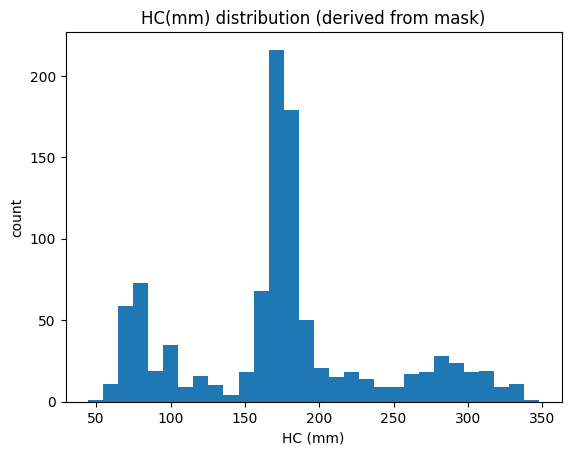

count    999.000000
mean     175.096601
std       65.501517
min       44.652886
25%      154.186590
50%      174.705923
75%      190.536625
max      347.814329
Name: hc_mm, dtype: float64


In [9]:
import matplotlib.pyplot as plt

plt.figure()
plt.hist(train_df["hc_mm"].values, bins=30)
plt.title("HC(mm) distribution (derived from mask)")
plt.xlabel("HC (mm)")
plt.ylabel("count")
plt.show()

print(train_df["hc_mm"].describe())


In [10]:
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as T

train_tfms = T.Compose([
    T.Resize((224, 224)),
    T.RandomHorizontalFlip(p=0.5),
    T.RandomRotation(10),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225]),
])

val_tfms = T.Compose([
    T.Resize((224, 224)),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225]),
])

class HCTrainDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df.reset_index(drop=True)
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        p = self.df.loc[idx, "img_path"]
        y = float(self.df.loc[idx, "hc_mm"])
        img = Image.open(p).convert("RGB")
        if self.transform:
            img = self.transform(img)
        y = torch.tensor([y], dtype=torch.float32)
        return img, y


In [11]:
from sklearn.model_selection import train_test_split

df_train, df_val = train_test_split(train_df, test_size=0.2, random_state=42)

ds_train = HCTrainDataset(df_train, transform=train_tfms)
ds_val   = HCTrainDataset(df_val, transform=val_tfms)

train_loader = DataLoader(ds_train, batch_size=32, shuffle=True, num_workers=2, pin_memory=True)
val_loader   = DataLoader(ds_val, batch_size=32, shuffle=False, num_workers=2, pin_memory=True)

print("train batches:", len(train_loader))
print("val batches  :", len(val_loader))


train batches: 25
val batches  : 7


In [12]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
from tqdm import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# Load pretrained ResNet18
model = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
model.fc = nn.Linear(model.fc.in_features, 1)  # regression head
model = model.to(device)

criterion = nn.L1Loss()          # MAE loss
optimizer = optim.Adam(model.parameters(), lr=1e-4)


Using device: cuda


In [13]:
def evaluate_mae(model, loader):
    model.eval()
    errs = []
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device)
            y = y.to(device)
            pred = model(x)
            errs.append(torch.abs(pred - y).cpu().numpy())
    return float(np.mean(np.concatenate(errs)))

best_val = 1e9
best_path = "/content/best_resnet18_hc_mm.pth"

EPOCHS = 20

for epoch in range(1, EPOCHS + 1):
    model.train()
    train_losses = []

    pbar = tqdm(train_loader, desc=f"Epoch {epoch}/{EPOCHS}")
    for x, y in pbar:
        x = x.to(device)
        y = y.to(device)

        optimizer.zero_grad()
        pred = model(x)
        loss = criterion(pred, y)
        loss.backward()
        optimizer.step()

        train_losses.append(loss.item())
        pbar.set_postfix(train_L1=np.mean(train_losses))

    val_mae = evaluate_mae(model, val_loader)
    print(f"[Epoch {epoch}] Train L1: {np.mean(train_losses):.3f} | Val MAE (mm): {val_mae:.3f}")

    if val_mae < best_val:
        best_val = val_mae
        torch.save(model.state_dict(), best_path)
        print("  ✅ Saved best model")

print("Best validation MAE (mm):", best_val)


Epoch 1/20: 100%|██████████| 25/25 [00:06<00:00,  3.80it/s, train_L1=172]


[Epoch 1] Train L1: 171.761 | Val MAE (mm): 174.452
  ✅ Saved best model


Epoch 2/20: 100%|██████████| 25/25 [00:05<00:00,  4.52it/s, train_L1=168]


[Epoch 2] Train L1: 168.385 | Val MAE (mm): 171.436
  ✅ Saved best model


Epoch 3/20: 100%|██████████| 25/25 [00:05<00:00,  4.57it/s, train_L1=166]


[Epoch 3] Train L1: 166.454 | Val MAE (mm): 170.004
  ✅ Saved best model


Epoch 4/20: 100%|██████████| 25/25 [00:05<00:00,  4.30it/s, train_L1=165]


[Epoch 4] Train L1: 164.868 | Val MAE (mm): 168.789
  ✅ Saved best model


Epoch 5/20: 100%|██████████| 25/25 [00:05<00:00,  4.65it/s, train_L1=163]


[Epoch 5] Train L1: 163.361 | Val MAE (mm): 166.763
  ✅ Saved best model


Epoch 6/20: 100%|██████████| 25/25 [00:05<00:00,  4.36it/s, train_L1=162]


[Epoch 6] Train L1: 161.858 | Val MAE (mm): 165.468
  ✅ Saved best model


Epoch 7/20: 100%|██████████| 25/25 [00:05<00:00,  4.53it/s, train_L1=160]


[Epoch 7] Train L1: 160.374 | Val MAE (mm): 163.654
  ✅ Saved best model


Epoch 8/20: 100%|██████████| 25/25 [00:05<00:00,  4.50it/s, train_L1=159]


[Epoch 8] Train L1: 158.879 | Val MAE (mm): 162.692
  ✅ Saved best model


Epoch 9/20: 100%|██████████| 25/25 [00:05<00:00,  4.60it/s, train_L1=157]


[Epoch 9] Train L1: 157.300 | Val MAE (mm): 160.565
  ✅ Saved best model


Epoch 10/20: 100%|██████████| 25/25 [00:05<00:00,  4.60it/s, train_L1=156]


[Epoch 10] Train L1: 155.688 | Val MAE (mm): 158.994
  ✅ Saved best model


Epoch 11/20: 100%|██████████| 25/25 [00:05<00:00,  4.60it/s, train_L1=154]


[Epoch 11] Train L1: 153.981 | Val MAE (mm): 157.391
  ✅ Saved best model


Epoch 12/20: 100%|██████████| 25/25 [00:05<00:00,  4.58it/s, train_L1=152]


[Epoch 12] Train L1: 152.340 | Val MAE (mm): 156.135
  ✅ Saved best model


Epoch 13/20: 100%|██████████| 25/25 [00:05<00:00,  4.62it/s, train_L1=151]


[Epoch 13] Train L1: 150.564 | Val MAE (mm): 153.894
  ✅ Saved best model


Epoch 14/20: 100%|██████████| 25/25 [00:05<00:00,  4.66it/s, train_L1=149]


[Epoch 14] Train L1: 148.738 | Val MAE (mm): 152.028
  ✅ Saved best model


Epoch 15/20: 100%|██████████| 25/25 [00:05<00:00,  4.60it/s, train_L1=147]


[Epoch 15] Train L1: 146.816 | Val MAE (mm): 150.164
  ✅ Saved best model


Epoch 16/20: 100%|██████████| 25/25 [00:05<00:00,  4.61it/s, train_L1=145]


[Epoch 16] Train L1: 144.838 | Val MAE (mm): 148.192
  ✅ Saved best model


Epoch 17/20: 100%|██████████| 25/25 [00:05<00:00,  4.56it/s, train_L1=143]


[Epoch 17] Train L1: 142.852 | Val MAE (mm): 146.324
  ✅ Saved best model


Epoch 18/20: 100%|██████████| 25/25 [00:05<00:00,  4.60it/s, train_L1=141]


[Epoch 18] Train L1: 140.755 | Val MAE (mm): 144.074
  ✅ Saved best model


Epoch 19/20: 100%|██████████| 25/25 [00:05<00:00,  4.50it/s, train_L1=139]


[Epoch 19] Train L1: 138.580 | Val MAE (mm): 141.915
  ✅ Saved best model


Epoch 20/20: 100%|██████████| 25/25 [00:05<00:00,  4.60it/s, train_L1=136]


[Epoch 20] Train L1: 136.357 | Val MAE (mm): 139.644
  ✅ Saved best model
Best validation MAE (mm): 139.64410400390625


In [14]:
%cd /content
!rm -rf mlmed2026
!git clone https://github.com/hoangnghia1444/mlmed2026.git
%cd /content/mlmed2026
!ls


/content
Cloning into 'mlmed2026'...
remote: Enumerating objects: 13, done.
remote: Counting objects: 100% (2/2), done.
remote: Compressing objects: 100% (2/2), done.
remote: Total 13 (delta 0), reused 0 (delta 0), pack-reused 11 (from 2)
Receiving objects: 100% (13/13), 39.45 KiB | 19.72 MiB/s, done.
Resolving deltas: 100% (1/1), done.
/content/mlmed2026
Medical_ML.ipynb  README.md  report-template.tex


In [16]:
import getpass
TOKEN = getpass.getpass("Paste GitHub PAT (token): ")


Paste GitHub PAT (token): ··········


In [17]:
%cd /content/mlmed2026

!cp "/content/drive/MyDrive/Prac2_ML_Medicine/Medical_ML_prac2.ipynb" /content/mlmed2026/Medical_ML_prac2.ipynb


!git status


!git add Medical_ML_prac2.ipynb
!git commit -m "Add Medical ML notebook prac2"
!git push


/content/mlmed2026
On branch main
Your branch is up to date with 'origin/main'.

Untracked files:
  (use "git add <file>..." to include in what will be committed)
	Medical_ML_prac2.ipynb

nothing added to commit but untracked files present (use "git add" to track)
Author identity unknown

*** Please tell me who you are.

Run

  git config --global user.email "you@example.com"
  git config --global user.name "Your Name"

to set your account's default identity.
Omit --global to set the identity only in this repository.

fatal: unable to auto-detect email address (got 'root@57879c9a56bf.(none)')
fatal: could not read Username for 'https://github.com': No such device or address
